## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn as sk
from sklearn import impute
import itertools as it

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, ParameterGrid, cross_val_predict, cross_val_score, cross_validate
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import time
from catboost import CatBoostClassifier

### Initial Data cleaning
*By Margaret Pirozzolo*

In [ ]:
# reading all three datasets
meta = pd.read_csv('movies_metadata.csv')
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

/var/folders/kq/x88bqfhj3yb4k2h4w6khqk8m0000gn/T/ipykernel_40937/3665773467.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('movies_metadata.csv')


In [ ]:
# turning the ID columns into numbers
def id_to_int(string):
    try:
        return int(string)
    except:
        return np.nan

meta.id = meta.id.apply(id_to_int)

# merging the datasets 
drop = pd.merge(meta, credits, on = 'id')
drop = pd.merge(drop, keywords, on = 'id')

# dropping columns that are recorded after the movie is released and hyper-specific columns
drop = drop.drop(labels = ['id','imdb_id','overview','poster_path','popularity',
                            'vote_average','vote_count', 'title','original_title'], axis = 1)

clean = drop.copy()

In [ ]:
# fills nans with 0 and 1 to make binary variable
def filled(string):
    if string is np.nan:
        string = 0
    else:
        string = 1
    return string

# turns bools into numbers
def vid(boo):
    try:
        boo = int(boo)
    except:
        boo = False
    return boo

In [ ]:
# functions to turn strange dictionary strings into readable data
def get_genre(string):
    try:
    # remove the curly braces from the string
        string = string.strip('[]')
        string = string.strip('{}')
 
    # split the string into key-value pairs
        pairs = string.split(', ')
        pairs = pairs[1]
        pairs = pairs.strip('}')
    
        return pairs[9:-1]
    except:
        return np.nan

def get_company(string):
    try:
    # remove the curly braces from the string
        string = string.strip('[]')
        string = string.strip('{}')
 
    # split the string into key-value pairs
        pairs = string.split(', ')
        pairs = pairs[0]
        pairs = pairs.strip('}')
    
        return pairs[9:-1]
    except:
        return np.nan
    
def get_country(string):
    try:
    # remove the curly braces from the string
        string = string.strip('[]')
        string = string.strip('{}')
 
    # split the string into key-value pairs
        pairs = string.split(', ')
        pairs = pairs[0]
        pairs = pairs.strip('}')
    
        return pairs[15:-1]
    except:
        return np.nan
    
def get_month(string):
    try:
        return str(string[5:7])
    except:
        return str(5)
    
def get_language(string):
    try:
    # remove the curly braces from the string
        string = string.strip('[]')
        string = string.strip('{}')
 
    # split the string into key-value pairs
        pairs = string.split(', ')
        pairs = pairs[0]
        pairs = pairs.strip('}')
    
        return pairs[14:-1]
    except:
        return np.nan

def get_person(string):
    try:
    # remove the curly braces from the string
        string = string.strip('[]')
        string = string.strip('{}')
 
    # split the string into key-value pairs
        pairs = string.split(', ')
        pairs = pairs[5]
    
        return pairs[9:-1]
    except:
        return np.nan
    
def get_actor(string):
    try:
    # remove the curly braces from the string
        string = string.strip('[]')
        string = string.strip('{}')
 
    # split the string into key-value pairs
        pairs = string.split(', ')
        pairs = pairs[5]
    
        return pairs[9:-1]
    except:
        return np.nan
    
def get_keyword(string):
    try:
    # remove the curly braces from the string
        string = string.strip('[]')
        string = string.strip('{}')
 
    # split the string into key-value pairs
        pairs = string.split(', ')
        pairs = pairs[1]
        pairs = pairs.strip('}')
    
        return pairs[9:-1]
    except:
        return np.nan



In [ ]:
# applying all the functions
clean.genres = drop.genres.apply(get_genre)
clean.belongs_to_collection = drop.belongs_to_collection.apply(filled)
clean.homepage = drop.homepage.apply(filled)
clean.tagline = drop.tagline.apply(filled)
clean.video = drop.video.apply(vid)
clean.production_companies = drop.production_companies.apply(get_company)
clean.production_countries = drop.production_countries.apply(get_country)
clean['release_month'] = drop.release_date.apply(get_month)
clean.spoken_languages = drop.spoken_languages.apply(get_language)
clean['top_crew'] = drop.crew.apply(get_person)
clean['top_cast'] = drop.cast.apply(get_actor)
clean['top_keyword'] = drop.keywords.apply(get_keyword)
clean = clean.drop(labels = ['cast','crew','keywords'], axis = 1)

In [ ]:
# turning budget into float
def budget_to_float(string):
    try:
        return float(string)
    except:
        return np.nan
    
clean.budget = clean.budget.apply(budget_to_float)

#creating profit column
clean['profit'] = clean.revenue - clean.budget

In [ ]:
def profitable(number):
    if number > 0.0:
        number = 1
    else:
        number = 0
    return number

#creating profitable binary column
clean['profitable'] = clean.profit
clean.profitable = clean.profitable.apply(profitable)
# dropping the columns to get there and exporting as a csv file
clean = clean.drop(["profit",'revenue'], axis = 1)
clean.to_csv('clean.csv')

### Data Preparation/EDA
*By Margaret Pirozzolo*

In [ ]:
data = pd.read_csv('clean.csv')
# looking at distribution of data
data.describe()

,Unnamed: 0,belongs_to_collection,budget,homepage,runtime,tagline,release_month,profitable
count,46628.000000,46628.000000,4.662800e+04,46628.000000,46360.000000,46628.000000,46628.000000,46628.000000
mean,23313.500000,0.098096,4.163636e+06,0.171764,94.086885,0.445719,6.452518,0.126190
std,13460.488513,0.297447,1.727426e+07,0.377179,38.454015,0.497050,3.632411,0.332067
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000
25%,11656.750000,0.000000,0.000000e+00,0.000000,85.000000,0.000000,3.000000,0.000000
50%,23313.500000,0.000000,0.000000e+00,0.000000,95.000000,0.000000,7.000000,0.000000
75%,34970.250000,0.000000,0.000000e+00,0.000000,107.000000,1.000000,10.000000,0.000000
max,46627.000000,1.000000,3.800000e+08,1.000000,1256.000000,1.000000,12.000000,1.000000


/Users/margaretpirozzolo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='profitable', ylabel='count'>

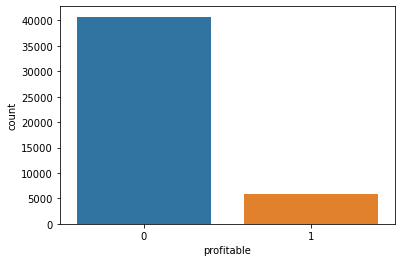

In [ ]:
# looking at distribution of outcome variable
sns.countplot(data.profitable)

In [ ]:
# undersampling the data to make it balanced
sample = pd.concat([data.loc[data.profitable == 0, :].sample(
    n=data['profitable'].sum(), replace = False, random_state=50), data.loc[data.profitable == 1, :]], axis=0)


sample = sample.drop(['Unnamed: 0'], axis = 1)


sample.profitable = sample.profitable.astype(int)
sample.profitable.sum()/len(sample)



0.5

/Users/margaretpirozzolo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='profitable', ylabel='count'>

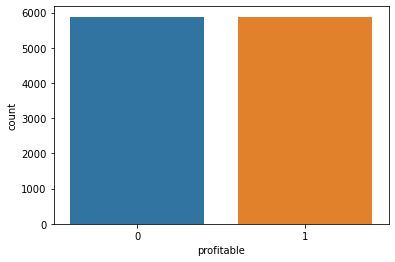

In [ ]:
sns.countplot(sample.profitable)

We tried to run some eda on all the columns, but after we created dummy variables, there were just far too many columns. We ended up dropping the hyper-specific columns with more than 100 unique values.

In [ ]:
print(len(pd.unique(sample['genres'])))

print(len(pd.unique(sample['top_crew'])))

print(len(pd.unique(sample['original_language'])))

print(len(pd.unique(sample['spoken_languages'])))

print(len(pd.unique(sample['top_keyword'])))

print(len(pd.unique(sample['top_cast'])))

print(len(pd.unique(sample['production_companies'])))

sample = sample.drop(['top_crew','top_cast','top_keyword','release_date','production_companies'], axis = 1)

sample.columns

21
6877
62
86
2229
5940
3568


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'production_countries', 'runtime',
       'spoken_languages', 'status', 'tagline', 'video', 'release_month',
       'profitable'],
      dtype='object')

In [ ]:
# imputing numeric columns

num_cols = sample._get_numeric_data().columns
num_sample = sample.loc[:,num_cols]

scaler = sk.preprocessing.MinMaxScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(num_sample))

imputer = impute.KNNImputer(n_neighbors=2)
imputed_arr_train = imputer.fit_transform(scaled_train)

unscaled_train = scaler.inverse_transform(imputed_arr_train)

imputed_sample = pd.DataFrame(unscaled_train)
imputed_sample.columns = num_sample.columns

In [ ]:
sample['belongs_to_collection'] = imputed_sample['belongs_to_collection']
sample['budget'] = imputed_sample['budget']
sample['homepage'] = imputed_sample['homepage']
sample['runtime'] = imputed_sample['runtime']
sample['profitable'] = imputed_sample['profitable']

In [ ]:
# imputing categorical columns
sample = sample.fillna(method = 'ffill')

In [ ]:
# splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    sample.drop("profitable", axis=1),
    sample.profitable,
    test_size=0.15,
    random_state=50)

In [ ]:
X_train_dummy = pd.get_dummies(X_train)
X_test_dummy = pd.get_dummies(X_test)

In [ ]:
# using lasso to select features

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
#standardizing the variables
scaler = StandardScaler()
scaler.fit(X_train_dummy)
Xstd = scaler.transform(X_train_dummy)

alphas = 10**np.linspace(1,-3,100)*0.5
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y_train)
    coefs.append(lasso.coef_)

lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y_train)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

lasso = Lasso(alpha =  lassocv.alpha_)
lasso.fit(Xstd, y_train)
lasso.coef_

from sklearn.feature_selection import SelectFromModel

sel_ = SelectFromModel(Lasso(alpha=lassocv.alpha_))
sel_.fit(np.array(X_train_dummy), y_train)

# make a list with the selected features and print the outputs
selected_features = X_train_dummy.columns[(sel_.get_support())]

In [ ]:
print(selected_features)

Index(['belongs_to_collection', 'homepage', 'runtime', 'tagline',
       'release_month', 'genres_Action', 'genres_Comedy', 'genres_Documentary',
       'genres_Drama', 'genres_Horror', 'production_countries_IN',
       'production_countries_US', 'spoken_languages_en'],
      dtype='object')


In [ ]:
X_train = X_train_dummy[selected_features]
X_test = X_test_dummy[selected_features]

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

In [6]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [7]:
X_train = X_train.drop(['Unnamed: 0'], axis = 1)
X_test = X_test.drop(['Unnamed: 0'], axis = 1)
y_train = y_train.drop(['Unnamed: 0'], axis = 1)
y_test = y_test.drop(['Unnamed: 0'], axis = 1)

### Random Forest
*By Lena Choe*

I developed a random forest model, tuning the hyperparameters that I thought were most important for the performance of this model.

In [ ]:
start_time = time.time()

params = {'n_estimators': [1000, 1500],
          'max_features': range(1,9),
          'max_depth': range(8, 20, 4),
          'max_leaf_nodes': range(30, 60, 4)
         }

param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
oob_accuracy = [0]*len(param_list)

i=0
for pr in param_list:
    model = RandomForestClassifier(random_state=1,
                                   oob_score=True,
                                   verbose=False,
                                   n_estimators = pr[0],
                                   max_features=pr[1], 
                                   max_depth=pr[2], 
                                   max_leaf_nodes=pr[3], 
                                   n_jobs=-1).fit(X_train,y_train)
    oob_accuracy[i] = model.oob_score_
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("max accuracy = ", np.max(oob_accuracy))
print("params= ", param_list[np.argmax(oob_recall)])

time taken =  51.60229480266571  minutes
max accuracy =  0.7809438112377525
params=  (1500, 3, 8, 58)


In [8]:
# random Forest
model_rf = RandomForestClassifier(random_state=1,
                                   oob_score=True,
                                   verbose=False,
                                   n_estimators = 1500,
                                   max_features=3, 
                                   max_depth=8, 
                                   max_leaf_nodes=58, 
                                   n_jobs=-1).fit(X_train,y_train.values.ravel())
# 0.65664355

In [ ]:
importances_rf = model_rf.feature_importances_
importances = pd.DataFrame({'Feature':X_train.columns,'importance':importances_rf})
importances.sort_values('importance', ascending = False)

,Feature,importance
1,budget,0.472273
4,tagline,0.200072
3,runtime,0.144662
0,belongs_to_collection,0.051776
2,homepage,0.039504
12,production_countries_US,0.026053
13,spoken_languages_en,0.019441
5,release_month,0.017205
8,genres_Documentary,0.008131
11,production_countries_IN,0.005834


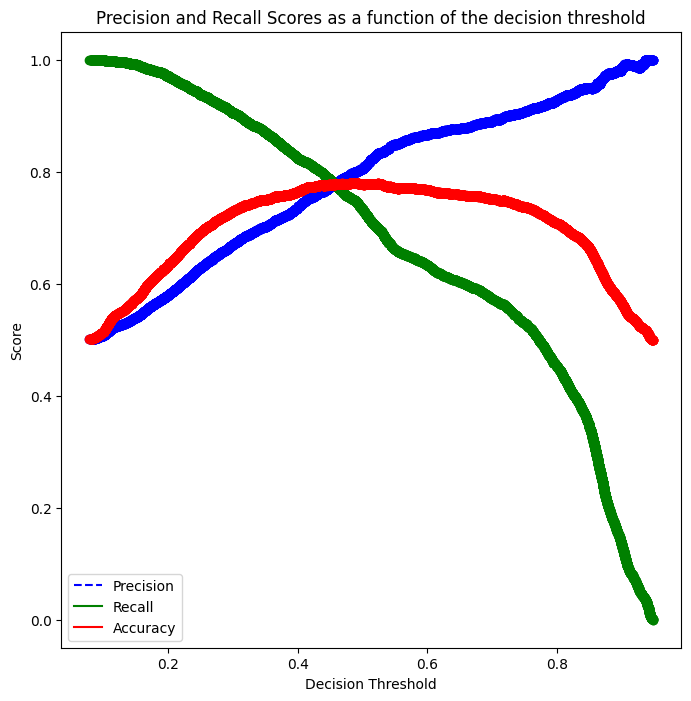

In [ ]:
y_pred_prob = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_pred_prob)
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = y_pred_prob > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), acc.reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_60 = all_thresholds[all_thresholds[:,2]>0.6,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probabiltiy for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_60[recall_more_than_60.shape[0]-1]

array([0.65664355, 0.75794841, 0.60003994])

Accuracy:  76.76464707058588
ROC-AUC:  0.8731209480130151
Precision:  0.8923976608187134
Recall:  0.6094249201277955


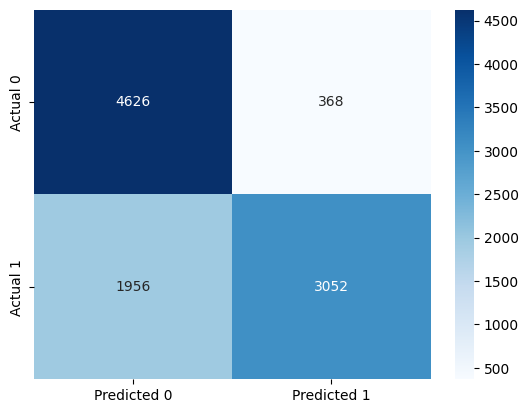

In [ ]:
# train

# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.65664355

y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  76.16081540203851
ROC-AUC:  0.8614552870555641
Precision:  0.8942807625649913
Recall:  0.589041095890411


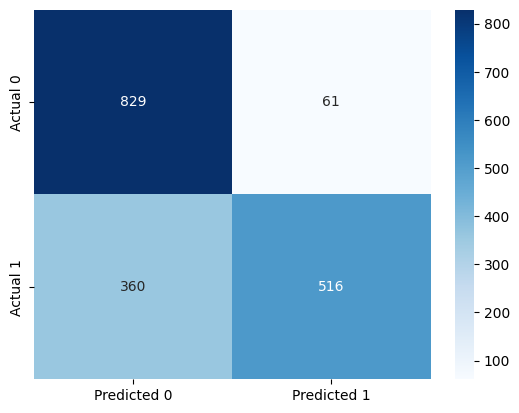

In [ ]:
# test

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### Adaptive Boosting
*By Sean Park*

In [ ]:
# adaptive Boosting
model_ada = AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=2),learning_rate=0.08,
                          n_estimators=900).fit(X_train,y_train.values.ravel())

In [ ]:
importances_ada = model_ada.feature_importances_
importances = pd.DataFrame({'Feature':X_train.columns,'importance':importances_ada})
importances.sort_values('importance', ascending = False)

,Feature,importance
3,runtime,0.345209
1,budget,0.329511
5,release_month,0.122461
12,production_countries_US,0.031989
0,belongs_to_collection,0.022286
6,genres_Action,0.021387
2,homepage,0.020696
13,spoken_languages_en,0.020636
11,production_countries_IN,0.016929
4,tagline,0.016096


### Gradient Boosting
*By Mehmet Ali Mehmetzade*

In [ ]:
# gradient Boosting
model_gb = GradientBoostingClassifier(random_state=1,max_depth=2,learning_rate=0.1,subsample=1,
                          n_estimators=500).fit(X_train, y_train.values.ravel())
# 0.425721729088532

In [ ]:
importances_gb = model_gb.feature_importances_
importances = pd.DataFrame({'Feature':X_train.columns,'importance':importances_gb})
importances.sort_values('importance', ascending = False)

,Feature,importance
1,budget,0.688318
3,runtime,0.118158
4,tagline,0.107053
0,belongs_to_collection,0.026426
2,homepage,0.017191
12,production_countries_US,0.013256
5,release_month,0.011512
10,genres_Horror,0.005411
7,genres_Comedy,0.005194
11,production_countries_IN,0.004000


### XGBoost
*By Margaret Pirozzolo*

Initially, I tried splitting the data by budget (if it had one or not), and tried training different XGBoost models on the two datasets, then combining them like we did in the prediction problem. However, this led to overfitting and poor performance. 

In [ ]:
X_train_trivial = X_train[X_train.budget == 0]
X_test_trivial = X_test[X_test.budget == 0]

train_triv_indeces = X_train_trivial.index
test_triv_indeces = X_test_trivial.index

y_train_trivial = y_train.iloc[train_triv_indeces]
y_test_trivial = y_test.iloc[test_triv_indeces]

X_train_nontrivial = X_train[X_train.budget != 0]
X_test_nontrivial = X_test[X_test.budget != 0]

train_indeces = X_train_nontrivial.index
test_indeces = X_test_nontrivial.index

y_train_nontrivial = y_train.iloc[train_indeces]
y_test_nontrivial = y_test.iloc[test_indeces]


In [ ]:
parameters = {'max_depth':[4,5,6,7,8,9,10,11,12],
              'n_estimators':range(100,7000,200), 
              'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2,0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.9], 
              'subsample':[0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9,1.0], 
              'reg_lambda':[0,1,2,3,4,5,6,7,8,9,10], 
              'gamma':[0,1,2,3,4,5,6,7,8,9,10]}
model = RandomizedSearchCV(xgb.XGBClassifier(random_state=45), param_distributions = parameters, n_iter = 200, 
                           n_jobs=-1, verbose=1, cv=5, scoring=['accuracy','recall'], refit="recall")
model.fit(X_train_nontrivial, y_train_nontrivial)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.9938456797439847 {'subsample': 1.0, 'reg_lambda': 10, 'n_estimators': 1100, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 9}


In [ ]:
parameters = {'max_depth':[4,5,6,7,8,9,10,11,12],
              'n_estimators':range(100,7000,200), 
              'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2,0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.9], 
              'subsample':[0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9,1.0], 
              'reg_lambda':[0,1,2,3,4,5,6,7,8,9,10], 
              'gamma':[0,1,2,3,4,5,6,7,8,9,10]}
model_triv = RandomizedSearchCV(xgb.XGBClassifier(random_state=45), param_distributions = parameters, n_iter = 200, 
                           n_jobs=-1, verbose=1, cv=5, scoring=['accuracy','recall'], refit="recall")
model_triv.fit(X_train_trivial, y_train_trivial)
print (model_triv.best_score_, model_triv.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.44286939911939915 {'subsample': 0.3, 'reg_lambda': 0, 'n_estimators': 4500, 'max_depth': 10, 'learning_rate': 0.5, 'gamma': 3}


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train_nontrivial)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
model_class = xgb.XGBClassifier(random_state=45, max_depth = 6 , n_estimators = 1100, 
                                  learning_rate = 0.01, subsample = 1, reg_lambda = 10, gamma = 9)
nontrivial_ypred = cross_val_predict(model_class, X_train_nontrivial.values, y_train_le, cv = 5, method = 'predict_proba')

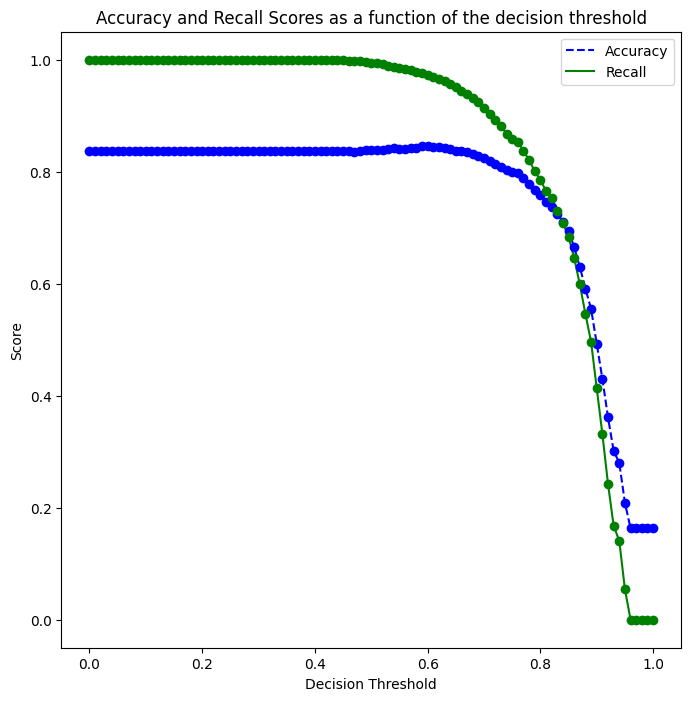

In [ ]:

accuracies = []
recalls = []

thresholds = np.arange(0,1.01,0.01)
for threshold in thresholds:
    predicted_class = nontrivial_ypred[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    accuracy = accuracy_score(y_train_nontrivial, predicted_class)
    accuracies.append(accuracy)
    recall = recall_score(y_train_nontrivial, predicted_class)
    recalls.append(recall)


def plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracies, "b--", label="Accuracy")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.plot(thresholds, accuracies, "o", color = 'blue')
    plt.plot(thresholds, recalls, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds)

In [ ]:
model_xg = model_class.fit(X_train_nontrivial, y_train_nontrivial)
model_triv = xgb.XGBClassifier(random_state=45, max_depth = 12 , n_estimators = 2700, 
                                learning_rate = 0.5, subsample = 0.3, 
                               reg_lambda = 0, gamma = 2).fit(X_train_trivial, y_train_trivial)

In [ ]:
optimal_threshold = 0.6
predicted_probability = model_xg.predict_proba(X_train_nontrivial)[:,1]
predicted_class = predicted_probability > optimal_threshold
nontrivial_pred = predicted_class.astype(int)

predicted_probability_triv = model_triv.predict_proba(X_train_trivial)[:,1]
predicted_class_triv = predicted_probability_triv > optimal_threshold
trivial_pred = predicted_class_triv.astype(int)

train_nontrivial_indeces = X_train_nontrivial.index
train_trivial_indeces = X_train_trivial.index
total_test_indeces = X_train.index
X_train_xg = X_train.copy()
X_train_xg['pred'] = [0]*10002


X_train_xg['pred'][train_nontrivial_indeces] = nontrivial_pred
X_train_xg['pred'][train_trivial_indeces] = trivial_pred


ac = accuracy_score(y_train,X_train_xg.pred)*100
rs = recall_score(y_train, X_train_xg.pred)*100

print('Total train accuracy: ', ac)
print('Total train Recall: ', rs)

Total train accuracy:  90.78184363127374
Total train Recall:  94.02955271565496


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
predicted_probability = model_xg.predict_proba(X_test_nontrivial)[:,1]
predicted_class = predicted_probability > optimal_threshold
nontrivial_pred = predicted_class.astype(int)

predicted_probability_triv = model_triv.predict_proba(X_test_trivial)[:,1]
predicted_class_triv = predicted_probability_triv > optimal_threshold
trivial_pred = predicted_class_triv.astype(int)

test_nontrivial_indeces = X_test_nontrivial.index
test_trivial_indeces = X_test_trivial.index
total_test_indeces = X_test.index
X_test_xg = X_test.copy()
X_test_xg['pred'] = [0]*1766

X_test_xg['pred'][test_nontrivial_indeces] = nontrivial_pred
X_test_xg['pred'][test_trivial_indeces] = trivial_pred

ac = accuracy_score(y_test,X_test_xg.pred)*100
rs = recall_score(y_test, X_test_xg.pred)*100

print('Total Test accuracy: ', ac)
print('Total Test Recall: ', rs)

Total Test accuracy:  71.85730464326161
Total Test Recall:  76.48401826484019


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


After seeing this overfitting, I decided to just train on the whole dataset, and got better performance. 

In [ ]:
parameters = {'max_depth':[4,5,6,7,8,9,10,11,12],
              'n_estimators':range(100,7000,200), 
              'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2,0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.9], 
              'subsample':[0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9,1.0], 
              'reg_lambda':[0,1,2,3,4,5,6,7,8,9,10], 
              'gamma':[0,1,2,3,4,5,6,7,8,9,10]}
model = RandomizedSearchCV(xgb.XGBClassifier(random_state=45), param_distributions = parameters, n_iter = 200, 
                           n_jobs=-1, verbose=1, cv=5, scoring=['accuracy','recall'], refit="recall")
model.fit(X_train, y_train)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.7522014911236468 {'subsample': 0.6, 'reg_lambda': 8, 'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0}


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le_total = le.fit_transform(y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
model_xgb = xgb.XGBClassifier(random_state=45, max_depth = 8 , n_estimators = 1100, 
                                  learning_rate = 0.01, subsample = 0.6, reg_lambda = 8, gamma = 0)
cross_val_ypred = cross_val_predict(model_xgb, X_train.values, y_train_le_total, cv = 5, method = 'predict_proba')

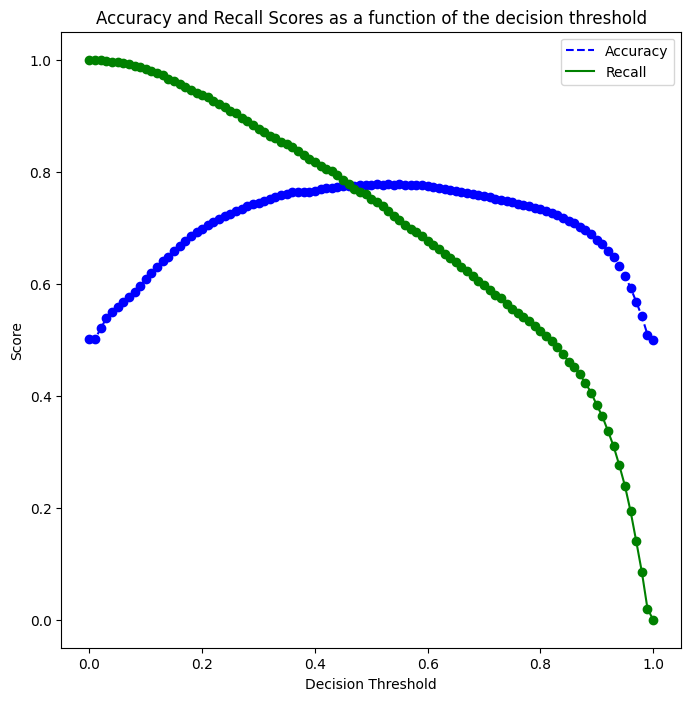

In [ ]:

accuracies = []
recalls = []

thresholds = np.arange(0,1.01,0.01)
for threshold in thresholds:
    predicted_class = cross_val_ypred[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    accuracy = accuracy_score(y_train, predicted_class)
    accuracies.append(accuracy)
    recall = recall_score(y_train, predicted_class)
    recalls.append(recall)


def plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracies, "b--", label="Accuracy")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.plot(thresholds, accuracies, "o", color = 'blue')
    plt.plot(thresholds, recalls, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds)

In [ ]:
#train
model_xgb = model_xgb.fit(X_train, y_train)

In [ ]:
predicted_probability = model_xgb.predict_proba(X_train)[:,1]

optimal_threshold = 0.46

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

    #Computing the accuracy
ac = accuracy_score(y_train, predicted_class)*100
rs = recall_score(y_train, predicted_class)*100
   

print('Train accuracy: ', ac)
print('Train Recall: ', rs)

Train accuracy:  83.04339132173565
Train Recall:  83.04712460063898


In [ ]:
predicted_probability = model_xgb.predict_proba(X_test)[:,1]

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

#Computing the accuracy and recall
ac = accuracy_score(y_test,predicted_class)*100
rs = recall_score(y_test, predicted_class)*100

print('Test accuracy: ', ac)
print('Test Recall: ', rs)

Test accuracy:  78.14269535673839
Test Recall:  77.3972602739726


In [ ]:
booster = model_xgb.get_booster()
importances_xg = booster.get_score()
importances = pd.DataFrame.from_dict(data=importances_xg, 
                                       orient='index')

importances.sort_values(0, ascending = False)

,0
runtime,32239.0
release_month,17903.0
budget,16013.0
production_countries_US,3875.0
homepage,3509.0
genres_Comedy,3113.0
spoken_languages_en,3099.0
tagline,3010.0
belongs_to_collection,2829.0
genres_Drama,2696.0


## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

In [ ]:
# hard voting ensemble (Margaret)
hv_model = VotingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)])
hv_model.fit(X_train,y_train.values.ravel())
hv_model.score(X_test, y_test.values.ravel())

0.7740656851642129

In [ ]:
# soft voting ensemble (Margaret)
sv_model = VotingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)],
                                 voting = 'soft')
sv_model.fit(X_train,y_train.values.ravel())
sv_model.score(X_test, y_test.values.ravel())

0.7774631936579841

### Stacking ensemble(s)

In [ ]:
#Using Logistic regression as the meta model (final_estimator) (Margaret)
logstack_model = StackingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)],
                                   final_estimator=LogisticRegression(random_state=1,max_iter=10000),n_jobs=-1,
                                   cv = 5)
logstack_model.fit(X_train,y_train.values.ravel())
logstack_model.score(X_test, y_test.values.ravel())

0.782559456398641

In [ ]:
cross_val_ypred = cross_val_predict(logstack_model, X_train.values, y_train_le_total, cv = 5, method = 'predict_proba')

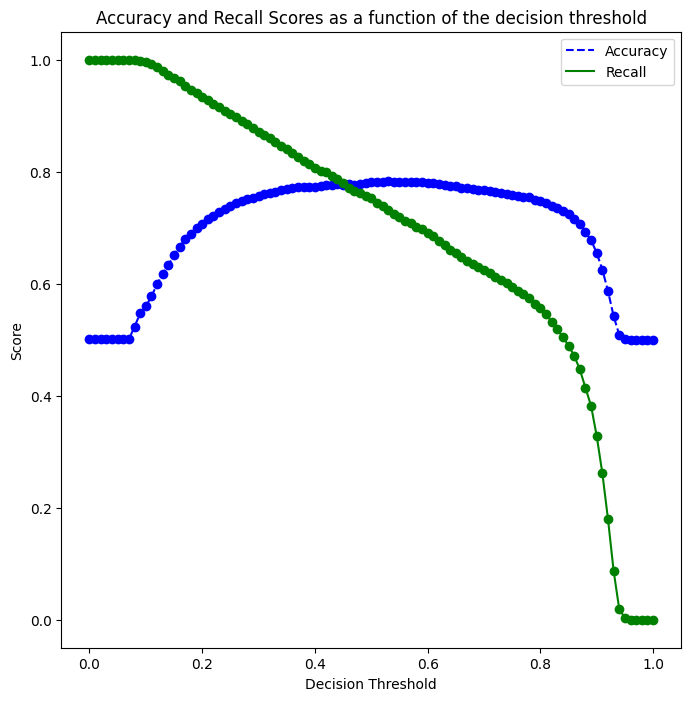

In [ ]:
accuracies = []
recalls = []

thresholds = np.arange(0,1.01,0.01)
for threshold in thresholds:
    predicted_class = cross_val_ypred[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    accuracy = accuracy_score(y_train, predicted_class)
    accuracies.append(accuracy)
    recall = recall_score(y_train, predicted_class)
    recalls.append(recall)


def plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracies, "b--", label="Accuracy")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.plot(thresholds, accuracies, "o", color = 'blue')
    plt.plot(thresholds, recalls, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds)

In [ ]:
np.column_stack([thresholds,accuracies,recalls])

array([[0.        , 0.50069986, 1.        ],
       [0.01      , 0.50069986, 1.        ],
       [0.02      , 0.50069986, 1.        ],
       [0.03      , 0.50069986, 1.        ],
       [0.04      , 0.50069986, 1.        ],
       [0.05      , 0.50069986, 1.        ],
       [0.06      , 0.50069986, 1.        ],
       [0.07      , 0.50069986, 1.        ],
       [0.08      , 0.52359528, 0.99880192],
       [0.09      , 0.54689062, 0.99740415],
       [0.1       , 0.55958808, 0.99640575],
       [0.11      , 0.57738452, 0.99221246],
       [0.12      , 0.5994801 , 0.98682109],
       [0.13      , 0.61687662, 0.97903355],
       [0.14      , 0.63337333, 0.97344249],
       [0.15      , 0.65096981, 0.96765176],
       [0.16      , 0.66636673, 0.96265974],
       [0.17      , 0.67976405, 0.95327476],
       [0.18      , 0.68936213, 0.9466853 ],
       [0.19      , 0.69956009, 0.94029553],
       [0.2       , 0.70625875, 0.93390575],
       [0.21      , 0.71495701, 0.92771565],
       [0.

In [ ]:
predicted_probability = logstack_model.predict_proba(X_train)[:,1]

optimal_threshold = 0.51

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

    #Computing the accuracy
ac = accuracy_score(y_train, predicted_class)*100
rs = recall_score(y_train, predicted_class)*100
   

print('Train accuracy: ', ac)
print('Train Recall: ', rs)

Train accuracy:  80.36392721455708
Train Recall:  77.27635782747603


In [ ]:
predicted_probability = logstack_model.predict_proba(X_test)[:,1]

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

#Computing the accuracy and recall
ac = accuracy_score(y_test,predicted_class)*100
rs = recall_score(y_test, predicted_class)*100

print('Test accuracy: ', ac)
print('Test Recall: ', rs)

Test accuracy:  78.2559456398641
Test Recall:  74.20091324200914


In [ ]:
#Using random forests as the meta model (final_estimator). (Margaret)
rfstack_model = StackingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)],
                                   final_estimator=RandomForestClassifier(n_estimators=700, max_features=1,
                                                                          random_state=1,oob_score=True),n_jobs=-1,
                                   cv = 5)
rfstack_model.fit(X_train,y_train.values.ravel())
rfstack_model.score(X_test, y_test.values.ravel())

0.7684031710079275

In [ ]:
cross_val_ypred = cross_val_predict(rfstack_model, X_train.values, y_train_le_total, cv = 5, method = 'predict_proba')

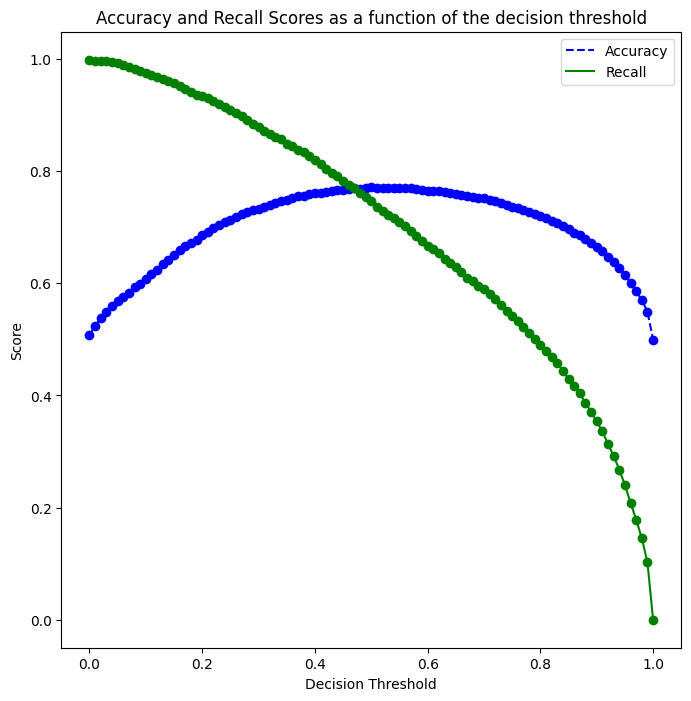

In [ ]:
accuracies = []
recalls = []

thresholds = np.arange(0,1.01,0.01)
for threshold in thresholds:
    predicted_class = cross_val_ypred[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    accuracy = accuracy_score(y_train, predicted_class)
    accuracies.append(accuracy)
    recall = recall_score(y_train, predicted_class)
    recalls.append(recall)


def plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracies, "b--", label="Accuracy")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.plot(thresholds, accuracies, "o", color = 'blue')
    plt.plot(thresholds, recalls, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds)

In [ ]:
predicted_probability = rfstack_model.predict_proba(X_train)[:,1]

optimal_threshold = 0.5

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

    #Computing the accuracy
ac = accuracy_score(y_train, predicted_class)*100
rs = recall_score(y_train, predicted_class)*100
   

print('Train accuracy: ', ac)
print('Train Recall: ', rs)

Train accuracy:  78.874225154969
Train Recall:  76.33785942492013


In [ ]:
predicted_probability = rfstack_model.predict_proba(X_test)[:,1]

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

#Computing the accuracy and recall
ac = accuracy_score(y_test,predicted_class)*100
rs = recall_score(y_test, predicted_class)*100

print('Test accuracy: ', ac)
print('Test Recall: ', rs)

Test accuracy:  76.84031710079276
Test Recall:  72.6027397260274


In [ ]:
#Tuning the random forest parameters (Margaret)
start_time = time.time()
oob_score = {}

i=0
for pr in range(1,5):
    model = StackingClassifier(estimators=[('ada',model_ada),('rf',model_rf),('gb',model_gb),('xgb',model_xgb)],
                                   final_estimator=RandomForestClassifier(n_estimators=700, max_features=pr,
                                    random_state=1,oob_score=True),n_jobs=-1,
                                   cv = 5).fit(X_train, y_train.values.ravel())
    oob_score[pr] = model.final_estimator_.oob_score_
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("max accuracy = ", np.max(list(oob_score.values())))
print("Best value of max_features= ", np.argmax(list(oob_score.values()))+1)

time taken =  3.0003421584765118  minutes
max accuracy =  0.7690461907618477
Best value of max_features=  1


This trained model output the same model as before. 

In [ ]:
#Using CatBoost as the meta model (Margaret)
catstack_model = StackingClassifier(estimators=[('ada',model_ada),('gb',model_gb),('xgb',model_xgb)],
                                   final_estimator=CatBoostClassifier(random_state=45, verbose = False),n_jobs=-1,
                                   cv = 5)
catstack_model.fit(X_train,y_train.values.ravel())
catstack_model.score(X_test, y_test.values.ravel())

0.7757644394110985

In [ ]:
cross_val_ypred = cross_val_predict(catstack_model, X_train.values, y_train_le_total, cv = 5, method = 'predict_proba')

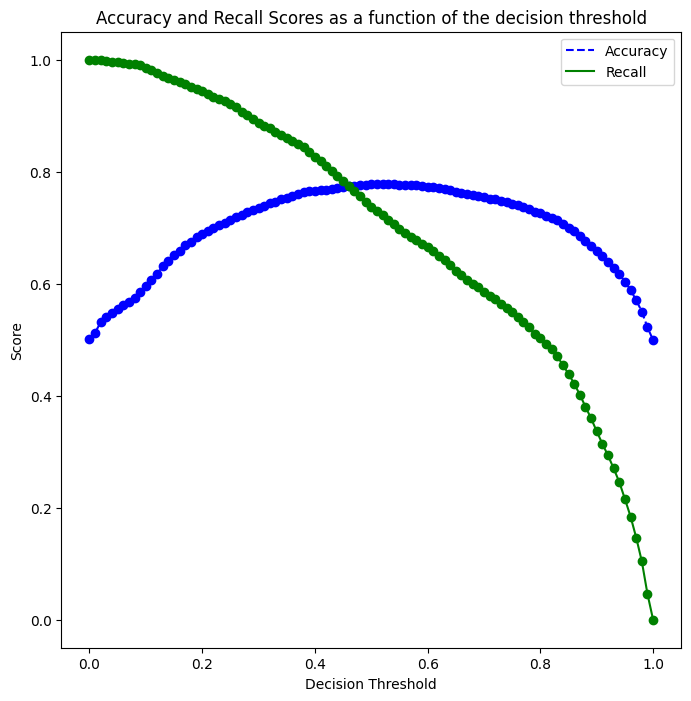

In [ ]:
accuracies = []
recalls = []

thresholds = np.arange(0,1.01,0.01)
for threshold in thresholds:
    predicted_class = cross_val_ypred[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    accuracy = accuracy_score(y_train, predicted_class)
    accuracies.append(accuracy)
    recall = recall_score(y_train, predicted_class)
    recalls.append(recall)


def plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracies, "b--", label="Accuracy")
    plt.plot(thresholds, recalls, "g-", label="Recall")
    plt.plot(thresholds, accuracies, "o", color = 'blue')
    plt.plot(thresholds, recalls, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracies, recalls, thresholds)

In [ ]:
predicted_probability = catstack_model.predict_proba(X_train)[:,1]

optimal_threshold = 0.52

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

    #Computing the accuracy
ac = accuracy_score(y_train, predicted_class)*100
rs = recall_score(y_train, predicted_class)*100
   

print('Train accuracy: ', ac)
print('Train Recall: ', rs)

Train accuracy:  79.39412117576484
Train Recall:  73.8817891373802


In [ ]:
predicted_probability = catstack_model.predict_proba(X_test)[:,1]

predicted_class = predicted_probability > optimal_threshold
predicted_class = predicted_class.astype(int)

#Computing the accuracy and recall
ac = accuracy_score(y_test,predicted_class)*100
rs = recall_score(y_test, predicted_class)*100

print('Test accuracy: ', ac)
print('Test Recall: ', rs)

Test accuracy:  77.06681766704416
Test Recall:  70.8904109589041
